In [31]:
import sys
sys.path.append('/home/ramana44/autoencoder-regularisation-')

import math
import numpy as np
from models import AE
import matplotlib.pyplot as plt
import torch.nn as nn
from activations import Sin
import copy
from  models_circle import ConvAE
from models_circle import BetaVAE, reconstruction_loss, kl_divergence, MLPVAE

pi = math.pi

def PointsInCircum(r,n=100):
    return [(math.cos(2*pi/n*x)*r,math.sin(2*pi/n*x)*r) for x in range(0,n+1)]

def PointsInCircumNDim(points, transform_to_nD):
    circle_nD = np.matmul(points, transform_to_nD)
    return circle_nD

In [32]:
import torch
I = torch.eye(5)
print(I)

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])


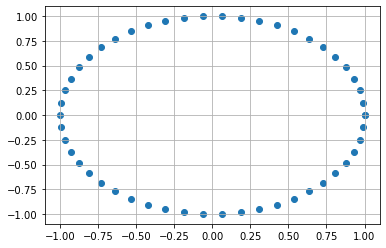

In [33]:
n = 50
points = PointsInCircum(1.,50)
arr_points = np.array(points)
plt.scatter(arr_points[:,0], arr_points[:,1])
plt.grid(True)
plt.show()

[[0.22084847 0.44008307 0.60621324]
 [0.90143347 0.56269558 0.41200512]]


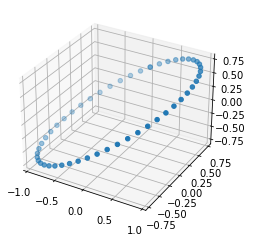

In [35]:
transform_to_3D = np.random.rand(2, 3)
print(transform_to_3D)
circle_3D = np.matmul(arr_points, transform_to_3D, )
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(circle_3D[:,0], circle_3D[:,1], circle_3D[:,2])

plt.show()


In [37]:
import torch
from torch.utils.data import DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch.utils.data import Dataset

class Dataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, index):
        return self.data[:, index]

def get_loader(data):
    dataset = Dataset(data)
    sampler = torch.utils.data.SubsetRandomSampler(list(range(data.shape[0])))
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=sampler)
    return loader

dim = 15
transform_to_nD = 4*np.random.rand(2, dim)-2
print(transform_to_nD)

data_tr = torch.from_numpy(PointsInCircumNDim(PointsInCircum(1.,3), transform_to_nD)).float()
data_val = torch.from_numpy(PointsInCircumNDim(PointsInCircum(1.,50), transform_to_nD)).float()
loader_tr = get_loader(data_tr)
loader_val = get_loader(data_val)

[[-1.27122113  1.57298055 -0.66644858 -0.65923252  1.28848284 -1.6670694
  -0.44252193 -1.06987685  1.1893967  -0.09610475 -1.67037068 -0.23427992
  -0.89898986 -1.9650229  -1.3550332 ]
 [-1.40101145 -1.24795249  0.20066566 -1.4564435  -1.76078005 -0.37870218
   1.95874351  1.51987889  0.6748161  -0.84784679 -1.75471132 -1.106696
   1.2654729   1.44512568  0.99610607]]


In [38]:
data_tr.shape

torch.Size([4, 15])

In [39]:
data_val

tensor([[-1.2712,  1.5730, -0.6664, -0.6592,  1.2885, -1.6671, -0.4425, -1.0699,
          1.1894, -0.0961, -1.6704, -0.2343, -0.8990, -1.9650, -1.3550],
        [-1.4368,  1.4042, -0.6360, -0.8366,  1.0576, -1.7014, -0.1935, -0.8709,
          1.2646, -0.2016, -1.8771, -0.3711, -0.7333, -1.7684, -1.2195],
        [-1.5797,  1.2132, -0.5956, -1.0007,  0.8101, -1.7089,  0.0585, -0.6583,
          1.3198, -0.3039, -2.0543, -0.5021, -0.5560, -1.5439, -1.0647],
        [-1.6977,  1.0031, -0.5458, -1.1491,  0.5498, -1.6894,  0.3096, -0.4352,
          1.3543, -0.4015, -2.1990, -0.6252, -0.3700, -1.2950, -0.8932],
        [-1.7889,  0.7772, -0.4873, -1.2793,  0.2808, -1.6433,  0.5558, -0.2053,
          1.3674, -0.4927, -2.3091, -0.7385, -0.1781, -1.0258, -0.7075],
        [-1.8519,  0.5390, -0.4212, -1.3894,  0.0074, -1.5713,  0.7933,  0.0278,
          1.3589, -0.5761, -2.3828, -0.8400,  0.0165, -0.7403, -0.5107],
        [-1.8857,  0.2924, -0.3485, -1.4776, -0.2661, -1.4745,  1.0183,  0.2

In [40]:
model = AE(dim, 6, 2, 2, Sin()).to(device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

401


In [41]:
model_conv = ConvAE(dim, no_filters=5, no_layers=2, 
                    kernel_size=3, latent_dim=2, activation=Sin()).to(device)
pytorch_total_params = sum(p.numel() for p in model_conv.parameters() if p.requires_grad)
print(pytorch_total_params)
#print(model_conv)

408


In [42]:
#del model_reg
hidden_size = 6
no_layers = 2
lr = 5e-3

no_filters = 5
kernel_size = 3
no_layers_conv = 2

'''
del model
del model_reg
del model_reg_ran
del model_reg_cheb
del model_reg_leg
'''

model = AE(dim, hidden_size, 2, no_layers, Sin()).to(device)
model_reg_tr = AE(dim, hidden_size, 2, no_layers, Sin()).to(device)
model_reg_ran = AE(dim, hidden_size, 2, no_layers, Sin()).to(device)
model_reg_cheb = AE(dim, hidden_size, 2, no_layers, Sin()).to(device)
model_reg_leg = AE(dim, hidden_size, 2, no_layers, Sin()).to(device)
model_conv = ConvAE(dim, no_filters, no_layers_conv, 
                    kernel_size, latent_dim=2, activation=Sin()).to(device)
model_vae = BetaVAE(dim, no_filters, no_layers_conv,
                  kernel_size, latent_dim=2, activation = Sin(), beta=0.01, use_mu=1.).to(device)
model_mlp_vae = MLPVAE(dim, hidden_size, 2, no_layers, beta=0.01).to(device)

#model_reg_tr = copy.deepcopy(model)
#model_reg_ran = copy.deepcopy(model)
#model_reg_cheb = copy.deepcopy(model)
#model_reg_leg = copy.deepcopy(model)

no_epochs = 550
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer_tr = torch.optim.Adam(model_reg_tr.parameters(), lr=lr)
optimizer_ran = torch.optim.Adam(model_reg_ran.parameters(), lr=lr)
optimizer_cheb = torch.optim.Adam(model_reg_cheb.parameters(), lr=lr)
optimizer_leg = torch.optim.Adam(model_reg_leg.parameters(), lr=lr)
optimizer_mlp_vae = torch.optim.Adam(model_mlp_vae.parameters(), lr=1e-3)

optimizer_conv = torch.optim.Adam(model_conv.parameters(), lr=5e-3)
optimizer_vae = torch.optim.Adam(model_vae.parameters(), lr=5e-3)

mod_loss = []
mod_loss_tr = []
mod_loss_ran = []
mod_loss_cheb = []
mod_loss_leg = []
mod_loss_conv = []
mod_loss_vae = []
mod_loss_mlp_vae = []

for epoch in range(no_epochs):
    optimizer.zero_grad()
    model_output = model(data_tr.to(device))
    loss = torch.nn.MSELoss()(model_output, data_tr.to(device))
    mod_loss.append(float(loss.item()))
    loss.backward()
    optimizer.step()
    
plt.plot(list(range(0,no_epochs)), mod_loss, label='baseline, '+str(mod_loss[-1]))
plt.xlabel("$epoch$")
plt.ylabel("$loss$")
#plt.title("Baseline model")
plt.grid(True)
#plt.show()

from regularisers_without_vegas import computeC1Loss, sampleChebyshevNodes, sampleLegendreNodes

regNodesSamplings = (["trainingData", "random", "chebyshev", "legendre",
                    "conv", "vae", "mlp_vae"])
                    
'''regNodesSamplings = (["legendre",
                    "conv", "vae", "mlp_vae"])'''

models = ([model_reg_tr, model_reg_ran, model_reg_cheb, model_reg_leg,
        model_conv, model_vae, model_mlp_vae])
optimizers = ([optimizer_tr, optimizer_ran, optimizer_cheb, optimizer_leg, 
            optimizer_conv, optimizer_vae, optimizer_mlp_vae])
szSample = 10
latent_dim = 2
weightJac = False
degPoly=20
alpha = 0.1
for ind, model_reg in enumerate(models):
    mod_loss_reg = []
    regNodesSampling = regNodesSamplings[ind]
    print(regNodesSampling)
    optimizer = optimizers[ind]
    #print(mod_loss_reg)
    for epoch in range(no_epochs):
        if (regNodesSampling != "conv") and (regNodesSampling != "vae") and (regNodesSampling != "mlp_vae"):
            model_output = model_reg(data_tr.to(device))
            loss = torch.nn.MSELoss()(model_output, data_tr.to(device))
            mod_loss_reg.append(float(loss.item()))

            if(regNodesSampling == 'chebyshev'):
                nodes_subsample_np, weights_subsample_np = sampleChebyshevNodes(szSample, latent_dim, weightJac, n=degPoly)
                nodes_subsample = torch.FloatTensor(nodes_subsample_np).to(device)
                weights_subsample = torch.FloatTensor(weights_subsample_np).to(device)
            elif(regNodesSampling == 'legendre'): 
                nodes_subsample_np, weights_subsample_np = sampleLegendreNodes(szSample, latent_dim, weightJac, n=degPoly)
                nodes_subsample = torch.FloatTensor(nodes_subsample_np).to(device)

                weights_subsample = torch.FloatTensor(weights_subsample_np).to(device)
            elif(regNodesSampling == 'random'):
                nodes_subsample = torch.FloatTensor(szSample, latent_dim).uniform_(-1, 1)
            elif(regNodesSampling == 'trainingData'):
                nodes_subsample = model_reg.encoder(data_tr[0:szSample, :].to(device))

            loss_C1, Jac = computeC1Loss(nodes_subsample, model_reg, device, guidanceTerm = False) #

            loss = (1.-alpha)*loss + alpha*loss_C1
        if regNodesSampling == "conv":
            model_output = model_reg(data_tr.to(device)).squeeze(1)
            loss = torch.nn.MSELoss()(model_output, data_tr.to(device))
            mod_loss_reg.append(float(loss.item()))
        if regNodesSampling == "vae":
            x_reco, mu, logvar = model_reg(data_tr.to(device))
            recon_loss = torch.nn.MSELoss()(data_tr.to(device), x_reco.squeeze(1))
            total_kld, dim_wise_kld, mean_kld = kl_divergence(mu, logvar)
            loss = recon_loss + model_vae.beta*total_kld
            mod_loss_reg.append(float(recon_loss.item()))
        if regNodesSampling == "mlp_vae":
            x_reco, mu, logvar = model_reg.forward(data_tr.to(device))
            recon_loss = torch.nn.MSELoss()(data_tr.to(device), x_reco)
            total_kld, dim_wise_kld, mean_kld = kl_divergence(mu, logvar)
            loss = recon_loss + model_vae.beta*total_kld
            mod_loss_reg.append(float(recon_loss.item()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    plt.plot(list(range(0,no_epochs)), mod_loss_reg, label=regNodesSampling+', '+str(mod_loss_reg[-1]))
    plt.xlabel("$epoch$")
    plt.ylabel("$loss$")
    plt.legend()
    plt.grid(True)
plt.show()

for opt in optimizers:
    del opt

trainingData
random
chebyshev
legendre


: 

: 

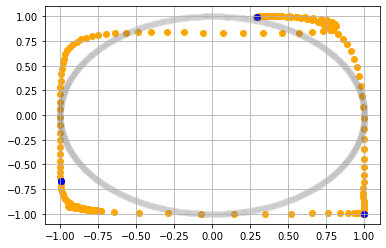

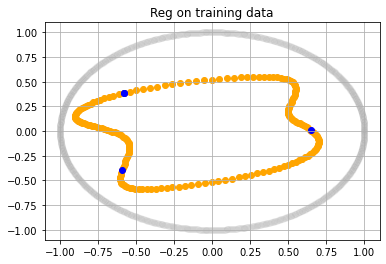

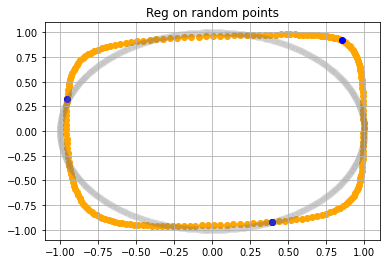

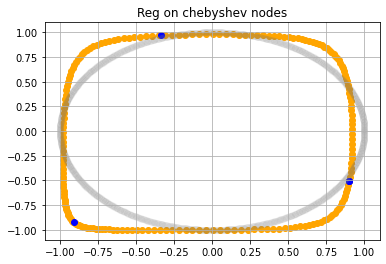

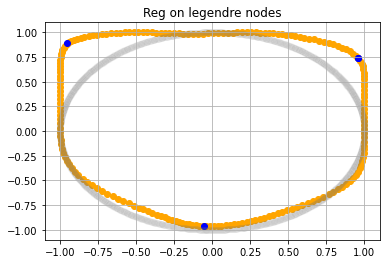

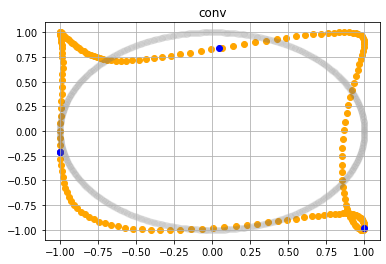

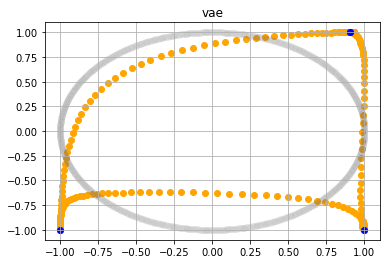

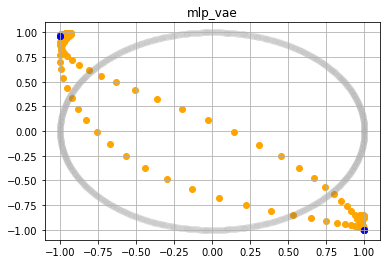

In [25]:
import matplotlib.pyplot as plt
points_tr = (model.encoder(data_tr.to(device))).detach().cpu().numpy()
points_val = (model.encoder(data_val.to(device))).detach().cpu().numpy()
plt.scatter(points_val[:,0], points_val[:,1], color="orange")
plt.scatter(points_tr[:,0], points_tr[:,1], color="blue")

plt.scatter(arr_points[:,0], arr_points[:,1], color='grey', alpha=0.05)
plt.grid(True)
#plt.title("Baseline: training data")
plt.show()


labels = ["Reg on training data", "Reg on random points", "Reg on chebyshev nodes", "Reg on legendre nodes","conv", "vae","mlp_vae"]
for ind, model_reg in enumerate(models):
    if ind < 5:
        points_tr = (model_reg.encoder(data_tr.to(device))).detach().cpu().numpy()
        points_val = (model_reg.encoder(data_val.to(device))).detach().cpu().numpy()
        plt.scatter(points_val[:,0], points_val[:,1], label='validation samples', color="orange")
        plt.scatter(points_tr[:,0], points_tr[:,1], label='training samples', color="blue")
        plt.scatter(arr_points[:,0], arr_points[:,1], color='grey', alpha=0.05)
        plt.grid(True)
        plt.title(labels[ind])
        plt.show()
    else:
        points_tr, _, _ = (model_reg.encode(data_tr.to(device), False))
        points_tr = points_tr.detach().cpu().numpy()
        points_val,_ ,_ = (model_reg.encode(data_val.to(device), False))
        points_val = points_val.detach().cpu().numpy()
        plt.scatter(points_val[:,0], points_val[:,1], label='validation samples', color="orange")
        plt.scatter(points_tr[:,0], points_tr[:,1], label='training samples', color="blue")
        plt.scatter(arr_points[:,0], arr_points[:,1], color='grey', alpha=0.05)
        plt.grid(True)
        plt.title(labels[ind])
        plt.show()
    del model_reg

-----RUN  0 -----
trainingData
random
chebyshev
legendre
conv


/home/willma32/.local/lib/python3.6/site-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


vae
mlp_vae
-----RUN  1 -----
trainingData
random
chebyshev
legendre
conv
vae
mlp_vae
-----RUN  2 -----
trainingData
random
chebyshev
legendre
conv
vae
mlp_vae
-----RUN  3 -----
trainingData
random
chebyshev
legendre
conv
vae
mlp_vae
-----RUN  4 -----
trainingData
random
chebyshev
legendre
conv
vae
mlp_vae
-----RUN  5 -----
trainingData
random
chebyshev
legendre
conv
vae
mlp_vae
-----RUN  6 -----
trainingData
random
chebyshev
legendre
conv
vae
mlp_vae
-----RUN  7 -----
trainingData
random
chebyshev
legendre
conv
vae
mlp_vae
-----RUN  8 -----
trainingData
random
chebyshev
legendre
conv
vae
mlp_vae
-----RUN  9 -----
trainingData
random
chebyshev
legendre
conv
vae
mlp_vae


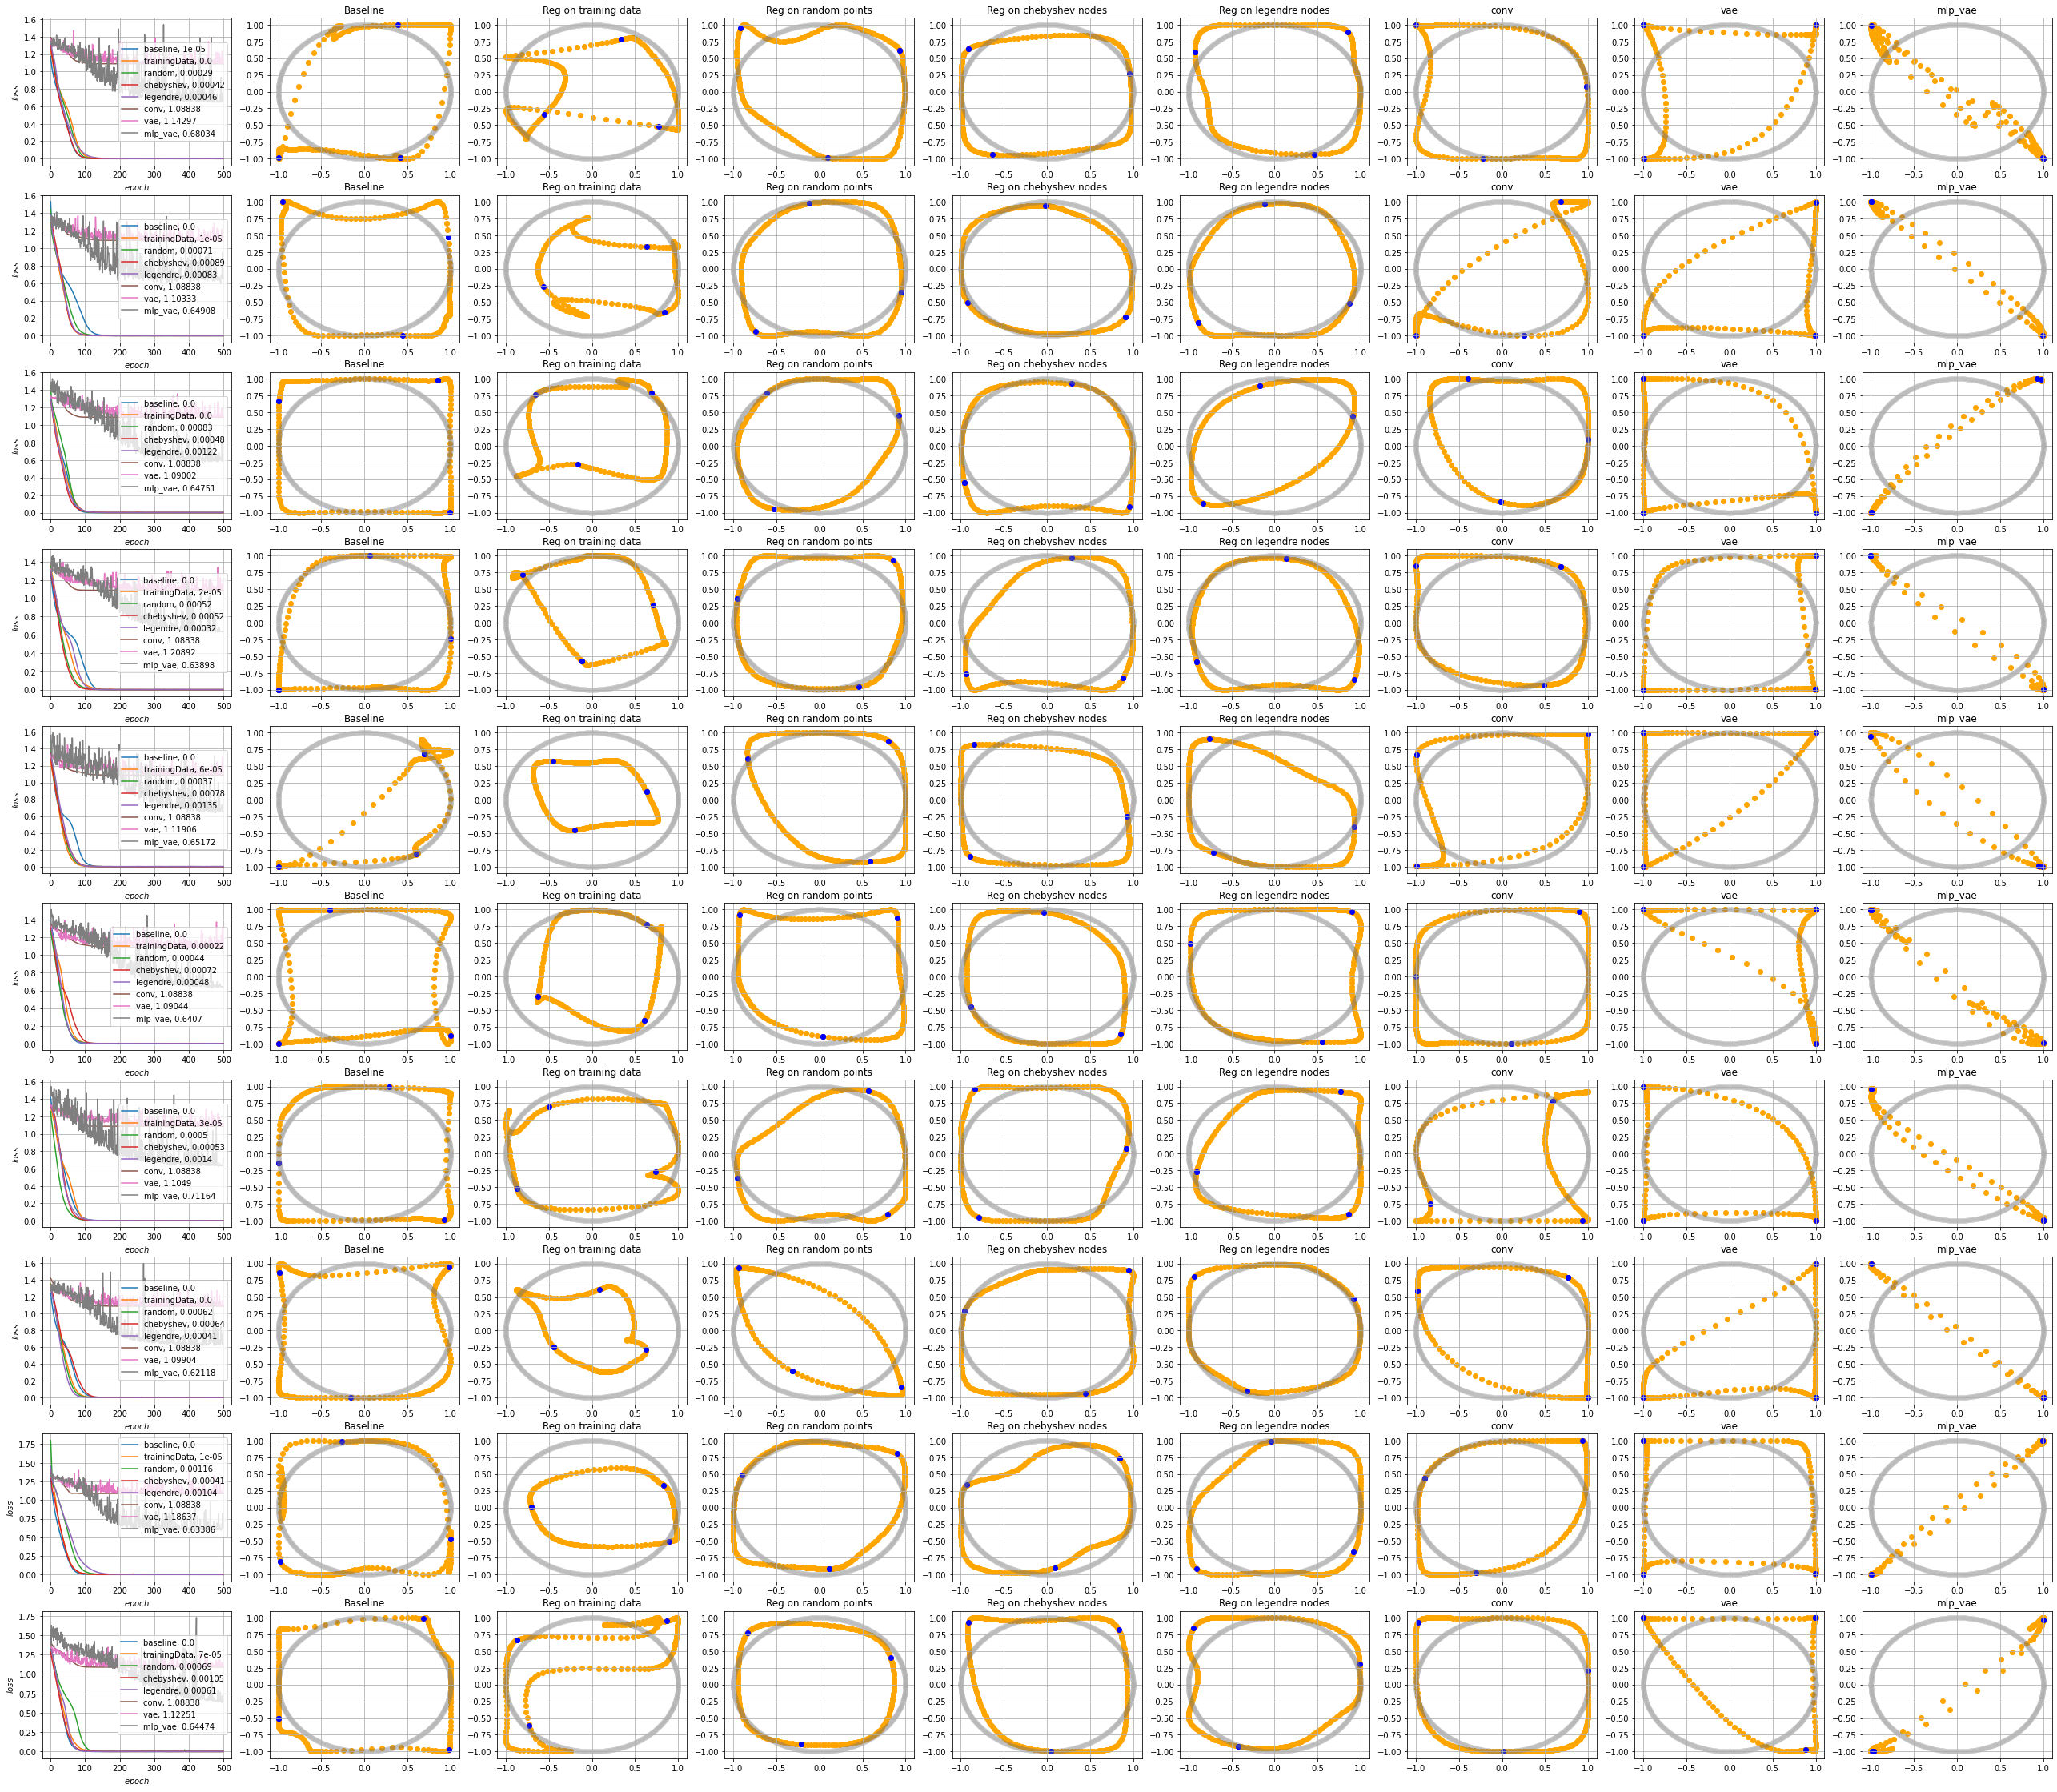

In [7]:
#del model_reg
hidden_size = 6
no_layers = 2
lr = 5e-3

no_filters = 5
kernel_size = 3
no_layers_conv = 2

szSample = 10
latent_dim = 2
weightJac = False
degPoly=20

alpha = 0.1
no_epochs = 500

'''
del model
del model_reg
del model_reg_ran
del model_reg_cheb
del model_reg_leg
'''
no_runs = 10
fig, ax = plt.subplots(no_runs, 9, figsize=(5*9, no_runs*4))
labels = ["Reg on training data", "Reg on random points", "Reg on chebyshev nodes", "Reg on legendre nodes","conv", "vae","mlp_vae"]
for i in range(no_runs):
    print('-----RUN ', i, '-----')
    model = AE(dim, hidden_size, 2, no_layers, Sin()).to(device)
    model_reg_tr = AE(dim, hidden_size, 2, no_layers, Sin()).to(device)
    model_reg_ran = AE(dim, hidden_size, 2, no_layers, Sin()).to(device)
    model_reg_cheb = AE(dim, hidden_size, 2, no_layers, Sin()).to(device)
    model_reg_leg = AE(dim, hidden_size, 2, no_layers, Sin()).to(device)
    model_conv = ConvAE(dim, no_filters, no_layers_conv, 
                        kernel_size, latent_dim=2, activation=Sin()).to(device)
    model_vae = BetaVAE(dim, no_filters, no_layers_conv,
                      kernel_size, latent_dim=2, activation = Sin(), beta=0.01, use_mu=1.).to(device)
    model_mlp_vae = MLPVAE(dim, hidden_size, 2, no_layers, beta=0.01).to(device)

    #model_reg_tr = copy.deepcopy(model)
    #model_reg_ran = copy.deepcopy(model)
    #model_reg_cheb = copy.deepcopy(model)
    #model_reg_leg = copy.deepcopy(model)


    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer_tr = torch.optim.Adam(model_reg_tr.parameters(), lr=lr)
    optimizer_ran = torch.optim.Adam(model_reg_ran.parameters(), lr=lr)
    optimizer_cheb = torch.optim.Adam(model_reg_cheb.parameters(), lr=lr)
    optimizer_leg = torch.optim.Adam(model_reg_leg.parameters(), lr=lr)
    optimizer_mlp_vae = torch.optim.Adam(model_mlp_vae.parameters(), lr=1e-3)

    optimizer_conv = torch.optim.Adam(model_conv.parameters(), lr=2e-3)
    optimizer_vae = torch.optim.Adam(model_vae.parameters(), lr=5e-3)

    mod_loss = []
    mod_loss_tr = []
    mod_loss_ran = []
    mod_loss_cheb = []
    mod_loss_leg = []
    mod_loss_conv = []
    mod_loss_vae = []
    mod_loss_mlp_vae = []

    for epoch in range(no_epochs):
        optimizer.zero_grad()
        model_output = model(data_tr.to(device))
        loss = torch.nn.MSELoss()(model_output, data_tr.to(device))
        mod_loss.append(float(loss.item()))
        loss.backward()
        optimizer.step()

    ax[i,0].plot(list(range(0,no_epochs)), mod_loss, label='baseline, '+str(round(mod_loss[-1],5)))
    ax[i,0].set_xlabel("$epoch$")
    ax[i,0].set_ylabel("$loss$")
    #plt.title("Baseline model")
    ax[i,0].grid(True)
    #plt.show()
    
    points_tr = (model.encoder(data_tr.to(device))).detach().cpu().numpy()
    points_val = (model.encoder(data_val.to(device))).detach().cpu().numpy()
    ax[i,1].scatter(points_val[:,0], points_val[:,1], color="orange")
    ax[i,1].scatter(points_tr[:,0], points_tr[:,1], color="blue")

    ax[i,1].scatter(arr_points[:,0], arr_points[:,1], color='grey', alpha=0.05)
    ax[i,1].grid(True)
    ax[i,1].set_title("Baseline")

    from regularisers import computeC1Loss, sampleChebyshevNodes, sampleLegendreNodes

    regNodesSamplings = (["trainingData", "random", "chebyshev", "legendre",
                        "conv", "vae", "mlp_vae"])
    models = ([model_reg_tr, model_reg_ran, model_reg_cheb, model_reg_leg,
            model_conv, model_vae, model_mlp_vae])
    optimizers = ([optimizer_tr, optimizer_ran, optimizer_cheb, optimizer_leg, 
                optimizer_conv, optimizer_vae, optimizer_mlp_vae])

    for ind, model_reg in enumerate(models):
        mod_loss_reg = []
        regNodesSampling = regNodesSamplings[ind]
        print(regNodesSampling)
        optimizer = optimizers[ind]
        #print(mod_loss_reg)
        for epoch in range(no_epochs):
            if (regNodesSampling != "conv") and (regNodesSampling != "vae") and (regNodesSampling != "mlp_vae"):
                model_output = model_reg(data_tr.to(device))
                loss = torch.nn.MSELoss()(model_output, data_tr.to(device))
                mod_loss_reg.append(float(loss.item()))

                if(regNodesSampling == 'chebyshev'):
                    nodes_subsample_np, weights_subsample_np = sampleChebyshevNodes(szSample, latent_dim, weightJac, n=degPoly)
                    nodes_subsample = torch.FloatTensor(nodes_subsample_np).to(device)
                    weights_subsample = torch.FloatTensor(weights_subsample_np).to(device)
                elif(regNodesSampling == 'legendre'): 
                    nodes_subsample_np, weights_subsample_np = sampleLegendreNodes(szSample, latent_dim, weightJac, n=degPoly)
                    nodes_subsample = torch.FloatTensor(nodes_subsample_np).to(device)

                    weights_subsample = torch.FloatTensor(weights_subsample_np).to(device)
                elif(regNodesSampling == 'random'):
                    nodes_subsample = torch.FloatTensor(szSample, latent_dim).uniform_(-1, 1)
                elif(regNodesSampling == 'trainingData'):
                    nodes_subsample = model_reg.encoder(data_tr[0:szSample, :].to(device))

                loss_C1, Jac = computeC1Loss(nodes_subsample, model_reg, device, guidanceTerm = False) #

                loss = (1.-alpha)*loss + alpha*loss_C1
            if regNodesSampling == "conv":
                model_output = model_reg(data_tr.to(device)).squeeze(1)
                loss = torch.nn.MSELoss()(model_output, data_tr.to(device))
                mod_loss_reg.append(float(loss.item()))
               
            if regNodesSampling == "vae":
                x_reco, mu, logvar = model_reg(data_tr.to(device))
                recon_loss = torch.nn.MSELoss()(data_tr.to(device), x_reco.squeeze(1))
                total_kld, dim_wise_kld, mean_kld = kl_divergence(mu, logvar)
                loss = recon_loss + model_vae.beta*total_kld
                mod_loss_reg.append(float(recon_loss.item()))
            if regNodesSampling == "mlp_vae":
                x_reco, mu, logvar = model_reg.forward(data_tr.to(device))
                recon_loss = torch.nn.MSELoss()(data_tr.to(device), x_reco)
                total_kld, dim_wise_kld, mean_kld = kl_divergence(mu, logvar)
                loss = recon_loss + model_vae.beta*total_kld
                mod_loss_reg.append(float(recon_loss.item()))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        ax[i,0].plot(list(range(0,no_epochs)), mod_loss_reg, label=regNodesSampling+', '+str(round(mod_loss_reg[-1],5)))
        ax[i,0].set_xlabel("$epoch$")
        ax[i,0].set_ylabel("$loss$")
        ax[i,0].legend()
        ax[i,0].grid(True)

    for ind, model_reg in enumerate(models):
        if ind < 5:
            points_tr = (model_reg.encoder(data_tr.to(device))).detach().cpu().numpy()
            points_val = (model_reg.encoder(data_val.to(device))).detach().cpu().numpy()
            ax[i, ind+2].scatter(points_val[:,0], points_val[:,1], label='validation samples', color="orange")
            ax[i, ind+2].scatter(points_tr[:,0], points_tr[:,1], label='training samples', color="blue")
            ax[i, ind+2].scatter(arr_points[:,0], arr_points[:,1], color='grey', alpha=0.05)
            ax[i, ind+2].grid(True)
            ax[i, ind+2].set_title(labels[ind])
        else:
            points_tr = (model_reg.encode(data_tr.to(device), False))[0].detach().cpu().numpy()
            points_val = (model_reg.encode(data_val.to(device), False))[0].detach().cpu().numpy()
            ax[i, ind+2].scatter(points_val[:,0], points_val[:,1], label='validation samples', color="orange")
            ax[i, ind+2].scatter(points_tr[:,0], points_tr[:,1], label='training samples', color="blue")
            ax[i, ind+2].scatter(arr_points[:,0], arr_points[:,1], color='grey', alpha=0.05)
            ax[i, ind+2].grid(True)
            ax[i, ind+2].set_title(labels[ind])

    

    #for ind in range(len(models)):
    #    del optimizers[ind]
    #    del models[ind]
plt.savefig('./10_runs')
plt.show()


<Figure size 432x288 with 0 Axes>

### np.save('/home/willma32/regularizedautoencoder/circle_data/training_data', data_tr.detach().cpu().numpy())
np.save('/home/willma32/regularizedautoencoder/circle_data/validation_data', data_val.detach().cpu().numpy())
torch.save({'model': model.state_dict()}, '/home/willma32/regularizedautoencoder/circle_data/model_base')
torch.save({'model': model_reg_tr.state_dict()}, '/home/willma32/regularizedautoencoder/circle_data/model_reg_tr')
torch.save({'model': model_reg_ran.state_dict()}, '/home/willma32/regularizedautoencoder/circle_data/model_reg_ran')
torch.save({'model': model_reg_cheb.state_dict()}, '/home/willma32/regularizedautoencoder/circle_data/model_reg_cheb')
torch.save({'model': model_reg_leg.state_dict()}, '/home/willma32/regularizedautoencoder/circle_data/model_reg_leg')

In [ ]:
import torch
from activations import Sin
device = 'cuda'

data_tr = torch.from_numpy(np.load('/home/willma32/regularizedautoencoder/circle_data/training_data.npy')).to('cuda')
data_val = torch.from_numpy(np.load('/home/willma32/regularizedautoencoder/circle_data/validation_data.npy')).to('cuda')
model = AE(dim, hidden_size, 2, no_layers, Sin()).to(device)
model.load_state_dict(torch.load('/home/willma32/regularizedautoencoder/circle_data/model_base')['model'])
                            
model_reg_tr = AE(dim, hidden_size, 2, no_layers, Sin()).to(device)
model_reg_tr.load_state_dict(torch.load('/home/willma32/regularizedautoencoder/circle_data/model_reg_tr')['model'])         
model_reg_ran = AE(dim, hidden_size, 2, no_layers, Sin()).to(device)
model_reg_ran.load_state_dict(torch.load('/home/willma32/regularizedautoencoder/circle_data/model_reg_ran')['model'])
model_reg_cheb = AE(dim, hidden_size, 2, no_layers, Sin()).to(device)
model_reg_cheb.load_state_dict(torch.load('/home/willma32/regularizedautoencoder/circle_data/model_reg_cheb')['model'])
model_reg_leg = AE(dim, hidden_size, 2, no_layers, Sin()).to(device)
model_reg_leg.load_state_dict(torch.load('/home/willma32/regularizedautoencoder/circle_data/model_reg_leg')['model'])

models = [model_reg_tr, model_reg_ran, model_reg_cheb, model_reg_leg]

In [ ]:
noValSamples=10
def plotJacobian(model, device, kind, latent_dim):
    fig, ax = plt.subplots(1,2,figsize=(16,8))
    plt.rcParams['axes.titlesize'] = 20
    torch.manual_seed(4242)
    Jac_val_pts = torch.FloatTensor(  np.random.uniform(-1,1,size=(noValSamples, latent_dim))   ).to(device)
    _, Jac = computeC1Loss(Jac_val_pts, model, device)
    magicNo, _, _, _ = Jac.shape
    
    Jac_m = torch.mean(Jac, axis=[0,2]) * magicNo
    rank_Jacm = float(torch.matrix_rank(Jac_m, tol=1e-1).cpu().detach().numpy())
    cond_Jacm = np.linalg.cond(Jac_m.detach().cpu().numpy())
    print("Rank_mean %d Cond_mean %.1e" % (rank_Jacm, cond_Jacm))
    
    plot0 = ax[0].imshow(Jac_m.squeeze().detach().cpu())
    ax[0].title.set_text(r'$\mu$'+'(Jacobian)'+"\nRank = %d; Cond = %.1e" % (rank_Jacm, cond_Jacm))
    cb = fig.colorbar(plot0, ax=ax[0])
    cb.ax.tick_params(labelsize=14)
    
    Jac_v = torch.var(Jac, unbiased=False, axis=[0,2]) * magicNo
    rank_Jacv = float(torch.matrix_rank(Jac_v, tol=1e-1).cpu().detach().numpy())
    cond_Jacv = np.linalg.cond(Jac_v.detach().cpu().numpy())
    print("Rank_var %d Cond_var %.1e" % (rank_Jacv, cond_Jacv))

    plot1 = ax[1].imshow(Jac_v.squeeze().detach().cpu())
    ax[1].title.set_text(r'$\sigma$'+'(Jacobian)'+"\nRank = %d; Cond = %.1e" % (rank_Jacv, cond_Jacv))
    cb = fig.colorbar(plot1, ax=ax[1])
    cb.ax.tick_params(labelsize='large')
    
    #plt.text(0.35, -0.05, ("Rank_mean %d Cond_mean %.1e\nRank_var %d Cond_var %.1e" % 
    #          (rank_Jacm, cond_Jacm, rank_Jacv, cond_Jacv)),
    #         fontsize=14, transform=plt.gcf().transFigure)
    #plt.savefig('./output/plotJacobian' + kind +'.png', dpi=300,
    #            bbox_inches='tight', pad_inches=0.2, edgecolor='w', facecolor="w")
    plt.show()
    plt.close()